In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path
import scipy.stats
import time

from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *
from open_spiel.python.examples.ubc_sample_game_tree import sample_game_tree, flatten_trees, flatten_tree
from open_spiel.python.examples.ubc_clusters import projectPCA, fitGMM
from open_spiel.python.examples.ubc_utils import *
from auctions.management.commands.ppo_eval import eval_command

from auctions.webutils import *

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"


from open_spiel.python.examples.ubc_cma import analyze_checkpoint

output_notebook()
from open_spiel.python.games.clock_auction_base import InformationPolicy
from open_spiel.python.algorithms.exploitability import nash_conv, best_response


Loading BokehJS ...

In [26]:
def compute_per_type_combo(state_fn, policy, game, **kwargs):
    """Compute some function of the initial state for each type combo.

    Args:
    - state_fn: (policy, state, **kwargs) -> value
    - policy: CFR policy
    - game: auction game
    - kwargs: passed to state_fn

    Returns:
    - results: dict of {type combination: value}
    """

    # Count number of types for each player
    # TODO: See ubc_cma type combos, this looks like a reinvention
    state = game.new_initial_state()
    num_types = []
    for player in range(game.num_players()):
        num_types.append(len(state.chance_outcomes()))
        state = state.child(0)

    # Test each type combo independently
    results = {}
    for combo in itertools.product(*[range(n) for n in num_types]):
        state = game.new_initial_state()
        for type in combo:
            state = state.child(type)

        results[combo] = state_fn(policy, state, **kwargs)
    return results

def min_prob(policy, state):
    if state.is_terminal():
        return []
    elif state.is_chance_node():
        chance_outcomes = state.chance_outcomes()
        if len(chance_outcomes) == 1:
            return min_prob(policy, state.child(0))
        else:
            return [
                min_prob(policy, state.child(action))
                for action, _ in state.chance_outcomes()
            ]
    else:
        action_probs = policy.action_probabilities(state)
        modal_action = max(action_probs, key=lambda x: action_probs[x])
        return [action_probs[modal_action]] + min_prob(policy, state.child(modal_action))

def get_demand_history(state, history_type='processed'):
    if not state.is_terminal():
        raise ValueError("State must be terminal")
    demand_fn = lambda bidder: bidder.processed_demand[1:] if history_type == 'processed' else bidder.submitted_demand[1:] # bidder -> (round, product)
    demand_histories = np.array([demand_fn(bidder) for bidder in state.bidders]) # (bidder, round, product)
    demand_histories = demand_histories.transpose(1, 0, 2) # (round, bidder, product)
    demand_histories = tuple(tuple(tuple(d) for d in round_demands) for round_demands in demand_histories) # convert to tuples for dict keys
    return demand_histories

def history_distribution(policy, state, min_prob=0.01, history_type='processed'):
    """Return the distribution over processed/submitted demand histories for the given policy and state.

    TODO: add an option to only include randomness from the policy, not from chance nodes?
    unsure if this would be interpretable (sum will be >1).
    """
    if state.is_terminal():
        history = get_demand_history(state, history_type)
        return {history: 1.0}

    else:
        dist = defaultdict(float)
        action_dist = state.chance_outcomes() if state.is_chance_node() else policy.action_probabilities(state).items()
        for action, action_prob in action_dist:
            if action_prob >= min_prob:
                dist2 = history_distribution(policy, state.child(action), min_prob=min_prob, history_type=history_type)
                for history, history_prob in dist2.items():
                    dist[history] += action_prob * history_prob
        return dist
    
def empirical_history_distribution(e):
    '''e is an Evaluation object'''
    processed_demand_series = pd.Series(zip(e.samples['processed_demands']['0'], e.samples['processed_demands']['1']))#.value_counts(normalize=True)
    type_series = pd.Series(zip(e.samples['types']['0'], e.samples['types']['1']))
    hist_df = pd.DataFrame({
        'processed_demand': processed_demand_series,
        'type': type_series
    })
    hist_df['processed_demand'] = hist_df['processed_demand'].apply(convert_nested_lists_to_tuples)
    return hist_df.groupby('type')['processed_demand'].value_counts(normalize=True)
    
def get_history_entropy(history_distribution):
    """Compute the entropy of a history distribution."""
    return scipy.stats.entropy(list(history_distribution.values()))


def convert_nested_lists_to_tuples(lst):
    if isinstance(lst, list) or isinstance(lst, tuple):
        return tuple(convert_nested_lists_to_tuples(x) for x in lst)
    return lst


In [27]:
# load runs from experiments
experiments = []
experiments += ['jun9ppo']
experiments += ['jun9outcome']
runs = []
for experiment in experiments:
    runs += Experiment.objects.get(name=experiment).equilibriumsolverrun_set.all()
print(f"Found {len(runs)} runs")

InterfaceError: connection already closed

# Analyze runs

In [5]:
game_cache = {}

def get_results(run, skip_single_chance_nodes=True):
    """Load the game, final checkpoint, and policy for a single run.
    """
    game = game_cache.get(run.game.name, run.game.load_as_spiel())
    game.auction_params.skip_single_chance_nodes = skip_single_chance_nodes # for backwards compatibility
    game_cache[run.game.name] = game

    final_checkpoint = run.equilibriumsolverruncheckpoint_set.last()
    policy = pickle.loads(final_checkpoint.policy)

    return game, final_checkpoint, policy

def get_algorithm_from_run(run):
    """Get the algorithm used for a run."""
    alg = run.config.get('solver_type', 'PPO')
    if alg == 'cfr':
        alg += '_' + run.config.get('sampling_method', '')
    return alg

def display_history_distributions(history_dists):
    for type_combo in history_dists:
        print(type_combo)
        for history, probs in history_dists[type_combo].items():
            print(f'{probs:.3f} {history}')
        print()

In [6]:
run = runs[0]

In [7]:
game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=False)


In [8]:
final_checkpoint.t

9999999

In [18]:
eval_command(final_checkpoint.t, run.experiment.name, run.name, None, None, dry_run=True, num_samples=1000)

{'rewards': array([0.47022091, 0.45461217]),
 'walltime': 2.991372585296631,
 'raw_rewards': defaultdict(list,
             {0: [9.0,
               9.0,
               29.799999999999997,
               9.0,
               95.0,
               9.0,
               95.0,
               9.0,
               29.799999999999997,
               95.0,
               9.0,
               42.19999999999999,
               95.0,
               9.0,
               9.0,
               29.799999999999997,
               29.799999999999997,
               95.0,
               9.0,
               9.0,
               42.19999999999999,
               9.0,
               95.0,
               9.0,
               9.0,
               9.0,
               29.799999999999997,
               95.0,
               95.0,
               95.0,
               9.0,
               42.19999999999999,
               42.19999999999999,
               9.0,
               42.19999999999999,
               95.0,
           

In [60]:
# # run = runs[0]
# run = EquilibriumSolverRun.objects.filter(experiment__name='jun2outcome', game__name='jun2/jun2_4_base.json').first()
# game, cp, policy = get_results(run, skip_single_chance_nodes=False)
# history_dists = compute_per_type_combo(history_distribution, policy, game, min_prob=0.01, history_type='processed')
# display_history_distributions(history_dists)


In [106]:
records = []
for run in tqdm(runs):
    if 'hide' in run.game.name: # FIXME: Just for now
        continue
    
    game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=False)
    
    # TODO: Look at processed demand hists from evals?
    empirical = True
    if empirical:
        history_dists = empirical_history_distribution(final_checkpoint.evaluation)
        history_entropies = [scipy.stats.entropy(list(history_dists.loc[type_combo].values)) for type_combo in np.unique(history_dists.index.get_level_values(0))]
    else:
        history_dists = compute_per_type_combo(history_distribution, policy, game, min_prob=0.01, history_type='processed')
        history_entropies = [scipy.stats.entropy(list(history_dists[type_combo].values())) for type_combo in history_dists]

    record = {
        # clock auction params
        'game_name': run.game.name, 
        'potential': run.config.get('potential_function', 'None'),
        'seed': run.config.get('seed'), 
        'run_name': run.name,

        # CMA knobs
        'information_policy': InformationPolicy(game.auction_params.information_policy).name,
        'clock_speed': game.auction_params.increment,
        'base_game_name': '_'.join(run.game.name.split('/')[1].split('_')[:2]), # Stupid naming convention that will surely bite us later

        # solver information
        'alg': get_algorithm_from_run(run),
        'walltime': run.walltime(),

        # metrics from eval
        **analyze_checkpoint(final_checkpoint),

        # stats about history distribution
        # 'avg_distinct_histories': np.mean([len(d) for d in history_dists.values()]),
        'avg_history_entropy': np.mean(history_entropies),
    } 
    
    # Slowwwwww you may want to comment this out when not using it
#     start = time.time()
#     record['nash_conv'] = nash_conv(game, final_checkpoint.get_model())
#     record['nash_conv_time'] = time.time() - start
#     print(time.time() - start)
    
    

    records.append(record)

  0%|                                                                                                                                                                                                                                                  | 0/45 [05:52<?, ?it/s]


KeyboardInterrupt: 

In [93]:
df = pd.DataFrame.from_records(records)

In [94]:
groupers = ['base_game_name', 'clock_speed', 'information_policy']
df.sort_values(groupers).set_index([df.index]+groupers, drop=True).to_csv('jun5_results.csv')

In [98]:
df.sort_values(groupers).set_index([df.index]+groupers, drop=True)
df['approx_uniform_ent'] = df['avg_history_entropy'].apply(np.exp)
df.to_csv('greg2.csv')

/tmp/ipykernel_5042/2907816583.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
/tmp/ipykernel_5042/2907816583.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
/tmp/ipykernel_5042/2907816583.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
/tmp/ipykernel_5042/2907816583.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


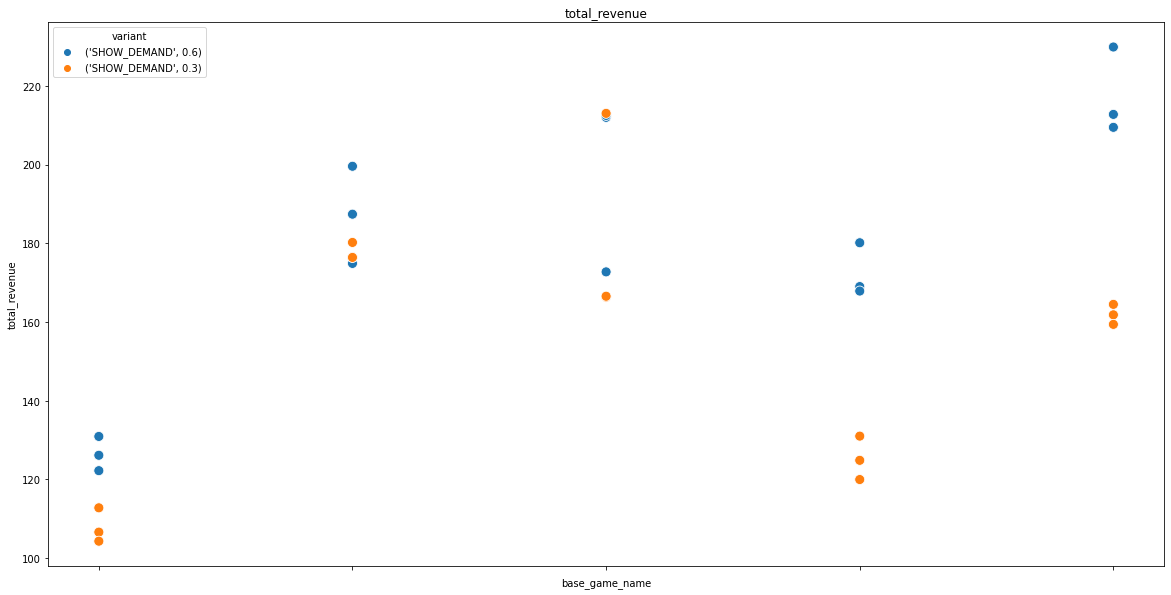

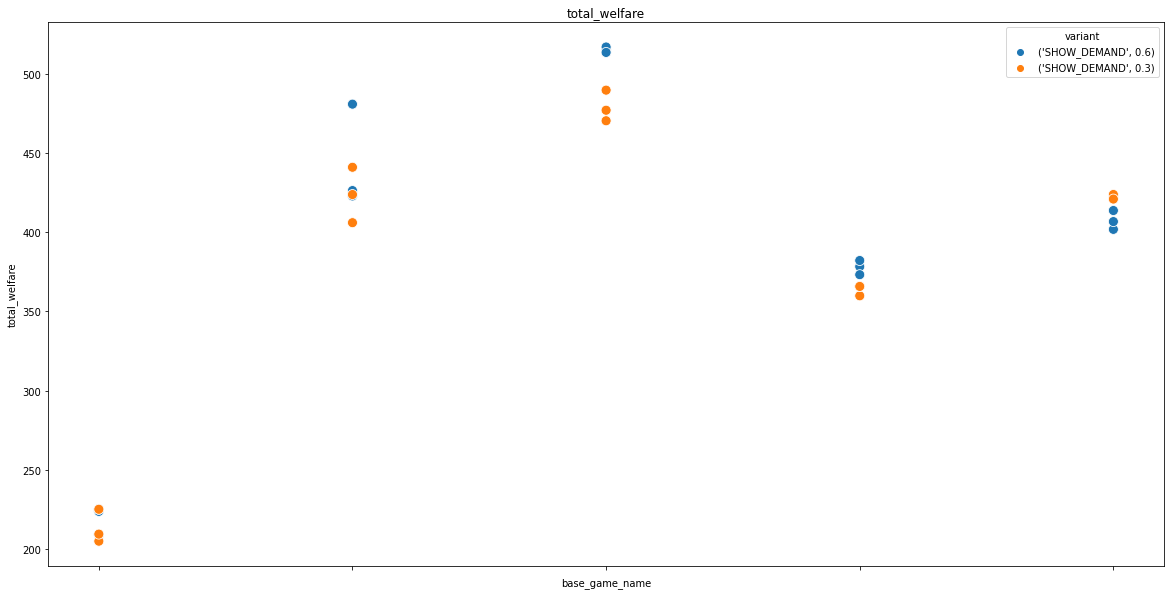

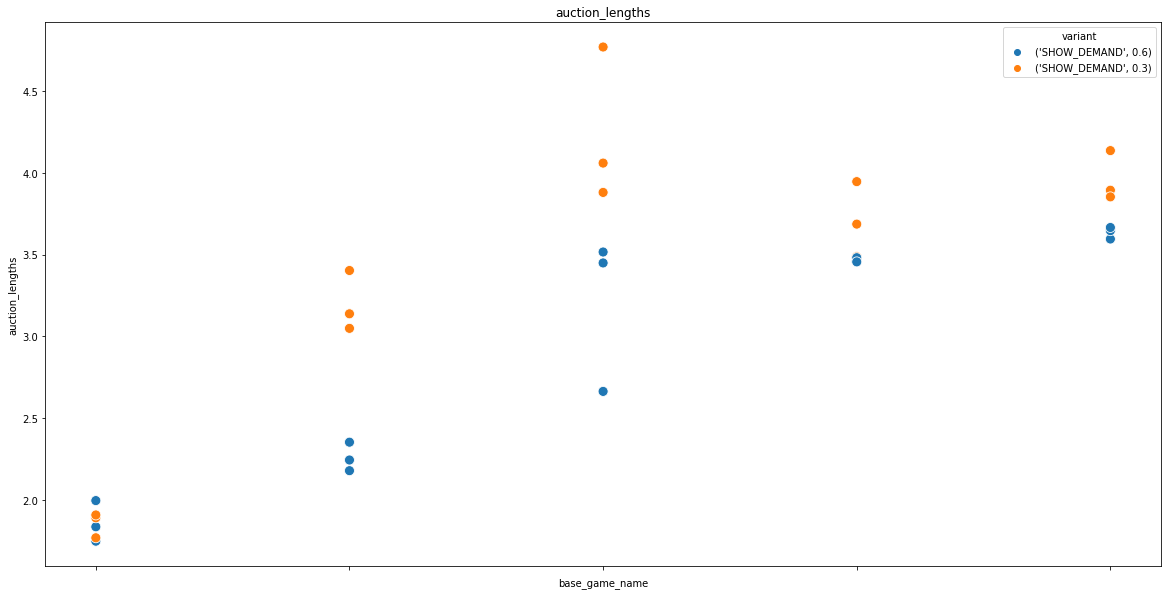

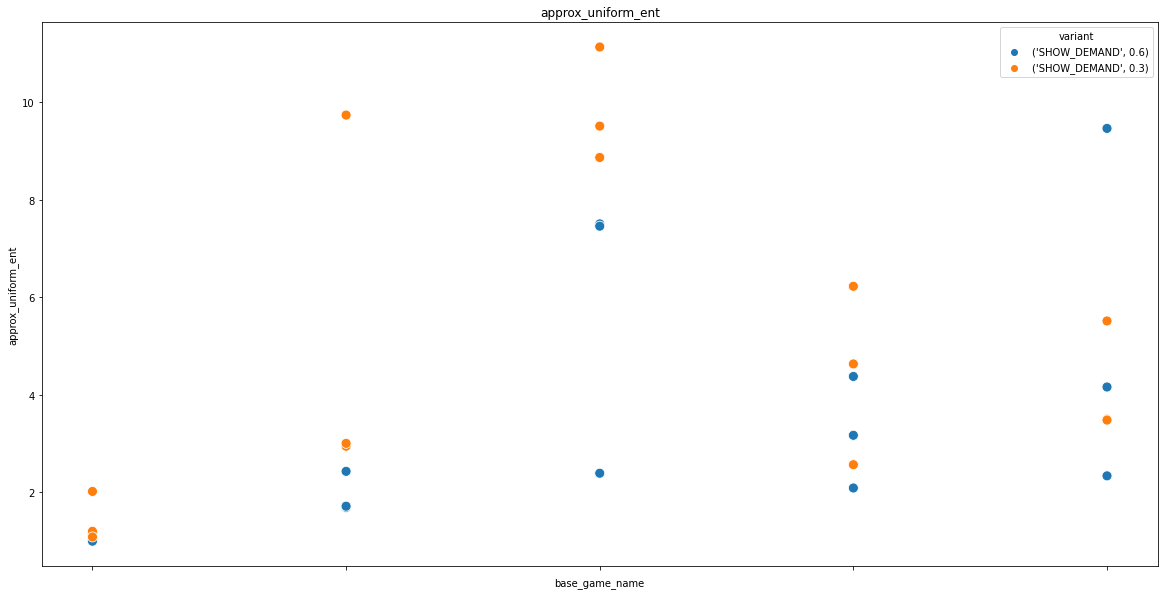

In [117]:
box_df = df.copy()
box_df['variant'] = list(map(str,(zip(box_df.information_policy, box_df.clock_speed))))
base = str(('SHOW_DEMAND', 0.3))
STATS = ['total_revenue', 'total_welfare', 'auction_lengths', 'approx_uniform_ent']
# Normalize by the mean of the "base" version, so the scales line up better in the same graph
for stat in STATS:
    base_stat = box_df.pivot_table(index='base_game_name', values=stat, aggfunc='mean', columns='variant')
    box_df[f'normalized_{stat}'] = box_df.apply(lambda x: x[stat] / base_stat.loc[x['base_game_name'], base], axis=1)
NORMALIZED = False
for stat in STATS:
    if NORMALIZED:
        stat = f'normalized_{stat}'
    plt.figure(figsize=(20,10))
    ax = sns.scatterplot(data=box_df, x='base_game_name', y=stat, hue='variant', s=100)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.title(f"{stat}")

In [ ]:
# ### Code to rerun evals for a failed experiment
# from open_spiel.python.examples.ubc_dispatch import dispatch_eval_database
# exp = 'jun5outcome'

# for e in Evaluation.objects.filter(checkpoint__equilibrium_solver_run__experiment__name=exp):
#     experiment_name = e.checkpoint.equilibrium_solver_run.experiment.name
#     run_name = e.checkpoint.equilibrium_solver_run.name
#     t = e.checkpoint.t
#     dispatch_eval_database(experiment_name, run_name, t, None, None)
# print(Evaluation.objects.filter(checkpoint__equilibrium_solver_run__experiment__name=exp).delete())

In [15]:
e = Evaluation.objects.last()

In [36]:
# Could break out by type?


array([(0, 0), (0, 1), (1, 0), (1, 1)], dtype=object)

In [83]:
for type_combo in np.unique(history_dists.index.get_level_values(0)):
    print(type_combo)

(0, 0)
(0, 1)
(1, 0)
(1, 1)


In [88]:
history_dists.loc[(0,0)].values

array([9.26558158e-01, 6.86780468e-02, 3.17586344e-03, 7.93965859e-04,
       3.96982930e-04, 3.96982930e-04])